**HW2VEC is a Graph Neural Network(GNN)-based hardware trojan detection tool whose source-code is available at https://github.com/AICPS/hw2vec**

The package versions and the commands (for setting up HW2VEC tool) mentioned in the above repo cause lot of errors as they are quite old. So, please don't follow them. After many iterations of trials and errors, the following commands (in order) worked for setting up the HW2VEC tool in my system. 

`git clone https://github.com/AICPS/hw2vec`

`conda create --name hw2vec_python37_pyg_pygraphviz`

`conda activate hw2vec_python37_pyg_pygraphviz`

`conda install python=3.7`

`conda install pyg -c pyg`

`python3 -m pip install pygraphviz`

`python3 -m pip install pydot pathlib patool pyunpack pyverilog`

`python3 -m pip install pytorch-nlp`

`python3 -m pip install scikit-image`

`python3 -m pip install pandas networkx matplotlib`

`conda list`

My system has:
1. **Ubuntu 20.04.4 LTS** (execute `lsb_release -d` in your Ubuntu terminal to see the version of your Ubuntu)
2. **Anaconda**
3. **CUDA 12** (execute `nvcc --version`in your Ubuntu terminal to see the CUDA version/availability (nvcc = nvidia cuda compiler))

Having set up the HW2VEC tool, let's execute the example script `hw2vec/graph2vec/models.py`. This script basically takes an input digital design (a Verilog file), converts it into a graph (in which each node has features or embeddings) and then, inputs the graph to a Graph Neural Network (GNN). The GNN transforms the node features into a new set of node features. This tranformed graph (with new node-features) can be used to train a Multi-Layered Perceptron (MLP).

I found some issues in the tool due to which the following steps -- **1-3** -- need to be performed before one can execute the script in **step 4**.

**Step 1:** Modify **line 105** of `hw2vec/graph2vec/models.py` as:

`self.load_state_dict(torch.load(model_weight_path, map_location=torch.device('cpu')),strict=False)`

**Step 2:** Modify **line 28** of `hw2vec/examples/use_case_1.py` as:

`hw_design_dir_path = Path("../assets/datasets/TJ-RTL-toy/TjFree/RS232/")`

Here, `RS232` is the directory containing the circuit-implementation of **RS232**. None of the circuits inside this directory can have the title `topModule.v`. Else, the `pre-process` function of `HW2GRAPH` class in `.hw2vec/hw2graph.py` can't execute on them.

**Step 3:** Unzip the assets/datasets.zip

**Step 4:** Execute the following command in the terminal:

`python use_case_1.py`

## Pyverilog

I setup the environment for installing Pyverilog in my system. The reason for doing this was to see if Pyverilog can process System Verilog files.

For installation steps, I referred to the [Pyverilog repo](https://github.com/PyHDI/Pyverilog) in Github.

I took an example file - *test.v* (available in the above repo) - and changed its extension to .sv. Then, I ran the `VerilogDataflowAnalyzer()` (provided by Pyverilog) on this file by running the following command available in the Pyverilog Github repo:

`python3 pyverilog/examples/example_dataflow_analyzer.py -t top test.sv`

The included files can have either ***.sv*** or ***.v*** extension as long as the extension is mentioned in the `include` statement. 

I ran the following command to run the `VerilogDataflowAnalyzer()` on the *.sv* files of Ariane's `axi_to_apb` module. 

`python3 ./examples/example_dataflow_analyzer.py ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/cva6_axi2apb_64_32_T3P4.sv ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/fifo_v3.sv ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/fifo_v2.sv ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/fifo_v1.sv ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/axi_w_buffer.sv ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/axi_single_slice.sv ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/axi_r_buffer.sv ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/axi_b_buffer.sv ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/axi_aw_buffer.sv ../hw2vec/assets/datasets/TJ-RTL-toy/TjIn/ariane_axi_to_apb/axi_ar_buffer.sv`

But, the Pyverilog parser seems to fail at a number of lines in the *.sv* files. It fails at many special constructs of the language. The following statements are some example lines from the Ariane code at which Pyverilog shows error.

`input  logic [AXI_NUMBYTES-1:0][7:0]   WDATA_i    ,`

`logic [1:0][31:0]              WDATA; `

 `enum logic [3:0] { IDLE, SINGLE_RD, SINGLE_RD_64, BURST_RD_1, BURST_RD, BURST_RD_64, BURST_WR, BURST_WR_64,
                    SINGLE_WR,SINGLE_WR_64, WAIT_R_PREADY, WAIT_W_PREADY} CS, NS;`
                    
 The errors go away when these lines were commented off from the code. But, these lines are part of the actual Ariane implementation.

## HW2VEC

**Just to be sure, I also ran the *.sv* files of Ariane's `axi_to_apb` module through the HW2VEC tooflow. It fails showing the same error as above.**

**However, both HW2VEC and Pyverilog successfully parsed through simpler *.v* and *.sv* codes without any error.** 

Like this hardware trojan detection method, there will be many other detection methods which not only lack in being tested for large-scale SoC-level designs but also in their ability to compile designs which use advanced features of the HDL.

The `examples`/`use_case_2.py` script performs 3 main tasks - converting hw circuits to graphs, configuring the GNN model, training the GNN model and evaluating the model.

Below are some modifications that I had to do in order to get the `examples`/`use_case_2.py` script functional:

1. `examples`/`use_case_2.py`: Comment off **lines 10**, **23 - 26** of this script. Indent **lines 11-21** properly. This is done because getting the graph data from cache (*i.e.,* the *.pkl* files in `examples`) doesn't work. The *.pkl* files `dfg_tj_rtl.pkl` and `ast_tj_rtl.pkl` don't contain the graphs of circuits and are empty.
2. `hw2vec`/`hw2graph.py`: Modify **line 148** to: 

class_weights = torch.from_numpy(compute_class_weight(**class_weight =** 'balanced', **classes=** np.unique(training_labels), **y =** training_labels))

The script can be run as usual without the `--data_pkl_path` option and just the `--graph_type`option (`DFG` or `AST`).

**Next, I need to understand how to view the prediction results of the pre-trained GNN model for trojan detection.**

## HW2VEC Tool Flow

HW2VEC consists of **HW2GRAPH** and **GRAPH2VEC** modules. 

**Step 1**: **HW2GRAPH** converts a hardware code ***p*** into a graph representation ***g*** -- an **AST** or **DFG**. In `hw2graph.py`, it carries out three tasks: **preprocessing** (`HW2GRAPH.preprocess`), **graph generation** (`HW2GRAPH.process`), and **postprocessing**. 

**Step 1a  (PREPROCESSING):** In `hw2graph.py`, there is the `HW2GRAPH` class, which has methods that **flatten**, **remove comments and underscores from**, and **rename the top module** of the hardware code.  

Since a hardware design can contain several modules stored in separate files, **the first step is to combine them into a single file through the process of flattening**. The `flatten` method uses the glob function from the `glob` module in Python in order to find all files containing a specific input path. For each file that is found, we append its contents to a string, called `flatten_content`, which is initially empty. Once we traverse through all the files, we write the `flatten_content` string to an output file, called `outfile`. Ultimately, this process ends up taking all the contents of files in a specific input path and putting them into a single file.

**Then, we remove comments and underscores from the flattened code**. 

`HW2GRAPH.rename_topModule` initializes an empty dictionary, called `modules_dic`, which is meant to store module names as *keys* and the module name frequency as the *values*. We then traverse through the lines in the flattened code and add any module name that is prefaced by the word `module` to the dictionary, initializing the value to 1 if there is a parenthesis in the module name and a 0 otherwise. we traverse through the lines in the flattened code again and if a word is a module name that is in the dictionary, we increment its frequency by 1. The module name that has a frequency of 1 is the top module, and we **rename it with the word “TOP”**.

 **Step 1b (GRAPH GENERATION):** After the preprocessing has completed, the hardware code must be converted into a graph representation: a **DFG** or an **AST**. In a DFG, the nodes usually represent mathematical operations and the edges represent the input and output dependencies between the nodes. An AST is a tree representation of the code, where each node is associated with a type that it represents. More specifically, the nodes could represent keywords, variables, etc. and the edges show the relationship between them. The purpose of ASTs in HW2VEC and in general is to capture the syntactic structure of hardware code.

**The code is first converted into a parse tree with the help of YACC (Yet Another Compiler-Compiler), a lexical analyzer that gives a structural representation of the hardware code.** 

<span style="color:red"> **PRINT THE PARSE TREE**</span>

**In order to produce the AST, we use a method called `ASTGenerator._generate_ast_dict` that iterates recursively through each node of the parse tree using a Depth First Search (DFS). The AST is in JSON (JavaScript Object Notation) format, which is a lightweight data format that is known for being readable and easy to parse by machines.**

<span style="color:red"> **PRINT THE AST**</span>

**In order to produce a DFG, we integrated PyVerilog (a hardware design toolkit for parsing the
Verilog code) into the tool. PyVerilog modules like `VerilogDataflowAnalyzer` and `VerilogGraphGenerator` are used to retrieve the DFG** `DFGGenerator.process` creates an instance of the `VerilogDataflowAnalyzer`
class, called `dataflow_analyzer`. The `VerilogDataflowAnalyzer.generate` outputs a parse tree also with the
help of YACC. An instance of the `VerilogGraphGenerator` is then created and assigned to the variable
name `dfg_graph_generator`. The `dfg_graph_generator` has a dictionary `binddict` whose keys are
nodes (the signals) and the values are each node’s associated dataflow object. For each signal in the
`binddict`, we call the `DFGGenerator.generate` to create a signal DFG. Lastly, we
merge all the signal DFGs together. **The resulting graph is a DFG that is also in JSON format.**

<span style="color:red"> **PRINT THE CONTENT OF THE `bindict` and the DFG**</span>

**Step 1c  (POST-PREPROCESSING): In the post-processing stage, we convert the JSON-formatted graph (DFG/AST) into a NetworkX graph object.** NetworkX is a Python package that allows for the creation
and manipulation of graphs and networks. It is an efficient, scalable, and highly portable framework for
graph analysis. In later stages, we will make use of the PyTorch-Geometric library -- a extension of PyTorch, useful for implementing and training GCNs. PyTorch is a machine learning library for Python programs. **Libraries like PyTorch Geometric take a NetworkX graph object as their primary data structure in their pipelines, so a conversion from JSON format to a NetworkX format is necessary.**


`nx_graph = nx.DiGraph()` :For both the DFG and AST, we initialize the NetworkX graph object, which we name `nx_graph`, as a NetworkX DiGraph object, which holds nodes and directed edges. 

<span style="color:red"> **PRINT THE CONTENT OF `nx_graph` before the nodes and edges are added** </span>

In `ASTGenerator.process`, we use the `ASTGenerator._add_node` to **add nodes and edges to the NetworkX graph object** based on the keys and values in the ast_dict. In `DFG.process`, we iterate through the nodes of the `dfg_graph_generator.graph` (a DFG graph object in JSON format) and use the `add_node` method of a NetworkX graph to add nodes to the DiGraph object.

<span style="color:red"> **PRINT THE CONTENT OF `nx_graph` after the nodes and edges are added** </span>

**Step 2: GRAPH2VEC** first converts the graph **g** (AST/DFG) into the matrices **X** (which represents the node embeddings) and **A** (which represents the adjacency information of the graph) and then creates a graph embedding model in `models.py` by executing the following steps: **graph convolution** (`GRAPH_CONV`), **graph pooling** (`GRAPH_POOL`), and **graph readout** (`GRAPH_READOUT`). 

**Step 2a (Generation of Feature Vector and Adjacency Matrix): At first, the `DataProcessor` class normalizes the NetworkX graph object by iterating through the nodes of the `nx_graph` and giving each node a label that indicates its type. All variable names are replaced with a high-level value type.** For the DFG, the type of the node can be *numeric*, *output*, *input*, or *signal*. The AST node can have a type of names or pure numeric, otherwise the type remains unchanged. **The label type is then used to convert each one of the nodes into a vectorized representation.** 

<span style="color:red"> **PRINT THE CONTENTS OF THESE NORMALISED GRAPHS AND THEIR LABELS** </span>

This happens in `DataProcessor.process` when we call `from_networkx`. `from_networkx` has an empty dictionary, `data`, which is filled with the graph’s nodes and edges. By calling `torch.tensor` on each item in data, we create feature vectors for each key in the dictionary. These feature vectors represent the node embeddings, **X**. `from_networkx` also creates an adjacency matrix **A** of the NetworkX graph object’s edges by calling `torch.LongTensor` on the list of the graph’s edges. This adjacency matrix, called `edge_index`, becomes an attribute of a dictionary, called data.

<span style="color:red"> **PRINT THE CONTENT OF `data` and its attributes X and A** </span>

**Step 2b (Graph Convolution):** HW2VEC then performs graph convolution operation through the `GRAPH_CONV` class. The `GRAPH_CONV` class performs graph convolutions by first creating a `GCNConv` object. The `GCNConv` class, which is imported from `torch_geometric.nn`. `GCNConv`, is initialized by passing as arguments, a graph convolution `type`
(string "gcn"), `in_channels` (which is an `int` representing the size of the number of nodes), and `out_channels` (which is an `int` showing the size of the output). The `GRAPH_CONV` class has a `forward` function whose arguments are the parameters `x` and `edge_index` that are basically **X** and **A**. The `forward` function returns the result of calling the `propagate` method, which is inherited from the `MessagePassing` class in `torch_geometric.nn.conv`. The `propagate` function internally calls the `message`, `aggregate`, and `update` methods. The `message` function normalizes the neighboring node features; the `aggregate` method accumulates the features of the neighboring nodes and produces an aggregated feature vector; the `update` method updates the previous node feature to the next feature vector. So, the `forward` function returns an updated feature matrix, *X<sup>prop</sup>*.

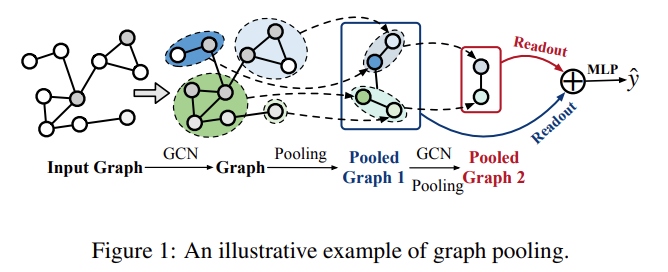

**Step 2c (Graph Pooling): This step performs graph pooling through the `GRAPH_POOL` class in `models.py`.** It uses an attention-based pooling layer to target a specific part of the graph. In this layer, a top-*k* filtering is performed on the nodes according to some scoring results.  In order to initialize a `GRAPH_POOL` instance, the user must pass in a type (string: *topkpool* or *sagpool*), the size of the input (int value assigned to `in_channels` parameter), and the pooling ratio, `poolratio`. Depending on the type that is passed to the constructor, we either create an instance of the `SAGPooling` class (self-attention graph pooling) or the `TopKPooling` class, both of which have been imported from `torch_geometric.nn`. Both `SAGPooling` and `TopKPooling` are instantiated by the same values assigned to `in_channels` and `poolratio` as the `GRAPH_POOL` class. `SAGPooling.forward` carries out the self-attention graph (SAG) pooling and takes feature vectors `x`, an adjacency matrix `edge_index`, and `batch` (a vector that indicates which nodes in the batch are a part of the same graph) as parameters. Essentially, the `forward` function returns *X*<sup>*pool*</sup> and *A*<sup>*pool*</sup> by performing top-k filtering, using the pooling ratio that was passed as an argument to the SAGPool constructor.  TopKPooling is done in the same manner as SAGPooling (`forward` method is identical). 

**Step 2c (Graph Readout):** The `GRAPH_READOUT` class will sum up or average up the features *X* of all nodes (left) after pooling to produce the node embeddings *h*<sub>*g*</sub> for each graph, *g*. In order to create an instance of `GRAPH_READOUT`, the user only needs to pass a `type` (string) to the constructor. Depending on the type, the forward function calls `global_max_pool`, `global_mean_pool`, or `global_add_pool`. After the graph readout step, the resulting graph embeddings of hardware designs then become compatible with ML algorithms.

<span style="color:red"> **PRINT THE GRAPH EMBEDDINGS PRODUCED BY THE GCN FOR A GIVEN HARDWARE DESIGN** </span>

**Step 3 (MLP Training and Testing): `GRAPH2VEC` has a `trainers.py` module that allows the user to perform training and testing of the model for hardware trojan or IP piracy detection.** The `trainers.py` module takes training datasets, validating datasets, and a set of hyperparameter configurations to train a GNN model. HW2VEC currently supports two types of trainers, a `GraphTrainer`
class and `PairwiseGraphTrainer` class. `GraphTrainer` and `PairwiseGraphTrainer` both inherit from the
`BaseTrainer` class. In its `build` method, `BaseTrainer` creates an instance of an Adam optimizer, which implements the Adam algorithm. In order to train the model for HT detection, the user should use the `GraphTrainer` class. An instance of `GraphTrainer` is created by passing a graph.


<span style="color:red"> **IMPORTANT DATA STRUCTURES IN THE HW2VEC TOOLFLOW:**</span>
1. **parse tree**
2. **AST**
3. **bindict**
4. **DFG**
5. **nx_graph**
6. **normalized networkx graphs**
7. **dictionary `data`**

## Hardware Trojan Detection (use_case_2.py)

The capability of detection at an early stage (particularly at RTL level) is crucial as removing HTs at later stages could be very expensive. The majority of existing solutions **rely on a golden HT-free reference** or **cannot generalize detection to previously unseen HTs**. 

**At first, we use HW2GRAPH** <span style="color:red">**(steps 1a-1b of above)**</span> **to convert each hardware design *p* into a graph *g*.** 

```python
cfg = Config(sys.argv[1:])

''' prepare graph data '''
if not cfg.data_pkl_path.exists():
    ''' converting graph using hw2graph '''
    nx_graphs = [] #list of graphs of all the circuits in the hw_project_path
    hw2graph = HW2GRAPH(cfg)
    for hw_project_path in hw2graph.find_hw_project_folders():
      hw_graph = hw2graph.code2graph(hw_project_path) #pre-process and process
      nx_graphs.append(hw_graph)
    print(f'nx_graphs: {nx_graphs}')
    data_proc = DataProcessor(cfg)
    for hw_graph in nx_graphs:
     data_proc.process(hw_graph)
    data_proc.cache_graph_data(cfg.data_pkl_path)
    
else:
    ''' reading graph data from cache '''
    data_proc = DataProcessor(cfg)
    print(f'data_proc: {data_proc}')
    data_proc.read_graph_data_from_cache(cfg.data_pkl_path) #sets self.graph_data
    

```
**Then, we do dataset preparation. We associate each `Data` instance with a label corresponding to whether a Trojan exists in the data.**

```python
''' prepare dataset '''
TROJAN = 1
NON_TROJAN = 0

all_graphs = data_proc.get_graphs() #stores self.graph_data
#print(f'all_graphs: {all_graphs}')
for data in all_graphs:
    print(f'data: {data}')
    if "TjFree" == data.hw_type:
        data.label = NON_TROJAN
    else:
        data.label = TROJAN
```

**After that, we split the entire dataset into two subsets for training and testing** depending on user-defined parameters such as ratio and seed. These splits are transformed into DataLoader instances so that PyTorch Geometric utilities can be leveraged.

```python
train_graphs, test_graphs = data_proc.split_dataset(ratio=cfg.ratio, seed=cfg.seed, dataset=all_graphs)
train_loader = DataLoader(train_graphs, shuffle=True, batch_size=cfg.batch_size)
valid_loader = DataLoader(test_graphs, shuffle=True, batch_size=1)
```

**We then initialize the GCN model and configure it by following** <span style="color:red">**steps 2a-2c.**</span> The user has the option to load a pre-trained model by altering the model_path argument in the command line, or they can define their own model’s design and hyperparameters by directly modifying the code. 
```python
''' model configuration '''
model = GRAPH2VEC(cfg)
if cfg.model_path != "":
    print(f'use_case_1.py if used!!!')
    model_path = Path(cfg.model_path)
    if model_path.exists():
        model.load_model(str(model_path/"model.cfg"), str(model_path/"model.pth"))
else:
    print(f'use_case_1.py else used!!!')
    convs = [
        GRAPH_CONV("gcn", data_proc.num_node_labels, cfg.hidden),
        GRAPH_CONV("gcn", cfg.hidden, cfg.hidden)
    ]
    model.set_graph_conv(convs)

    pool = GRAPH_POOL("sagpool", cfg.hidden, cfg.poolratio)
    model.set_graph_pool(pool)

    readout = GRAPH_READOUT("max")
    model.set_graph_readout(readout)

    output = nn.Linear(cfg.hidden, cfg.embed_dim)
    model.set_output_layer(output)
```

**We then start training** <span style="color:red"> **(step 3)**</span> **the model** using the `GraphTrainer` class. Calling the `build` function will assign the model to the trainer and create an Adam optimizer. Then, calling the `train` function will train the
graph embeddings with a cross-entropy loss function for the Adam optimizer while also performing mini-
tests.

```python
''' training '''
model.to(cfg.device)
trainer = GraphTrainer(cfg, class_weights=data_proc.get_class_weights(train_graphs))
trainer.build(model)
trainer.train(train_loader, valid_loader)
```
**Then, we perform a final test to observe the performance of the model for TJ detection** by calling the evaluate function.
```python
''' evaluating and inspecting '''
trainer.evaluate(cfg.epochs, train_loader, valid_loader)
vis_loader = DataLoader(all_graphs, shuffle=False, batch_size=1)
trainer.visualize_embeddings(vis_loader, "./")
```